In [102]:
import os
import topogenesis as tg
import pyvista as pv
import trimesh as tm
import numpy as np
from ladybug.sunpath import Sunpath

# convert mesh to pv_mesh
def tri_to_pv(tri_mesh):
    faces = np.pad(tri_mesh.faces, ((0, 0),(1,0)), 'constant', constant_values=3)
    pv_mesh = pv.PolyData(tri_mesh.vertices, faces)
    return pv_mesh

In [103]:
envelope_path = os.path.relpath('../data/meshes/compulsory_envelope.obj')
context_path = os.path.relpath('../data/meshes/immediate_context.obj')

# load the mesh from file
envelope_mesh = tm.load(envelope_path)
context_mesh = tm.load(context_path)

# Check if the mesh is watertight
print(envelope_mesh.is_watertight)
print(context_mesh.is_watertight)

True
False


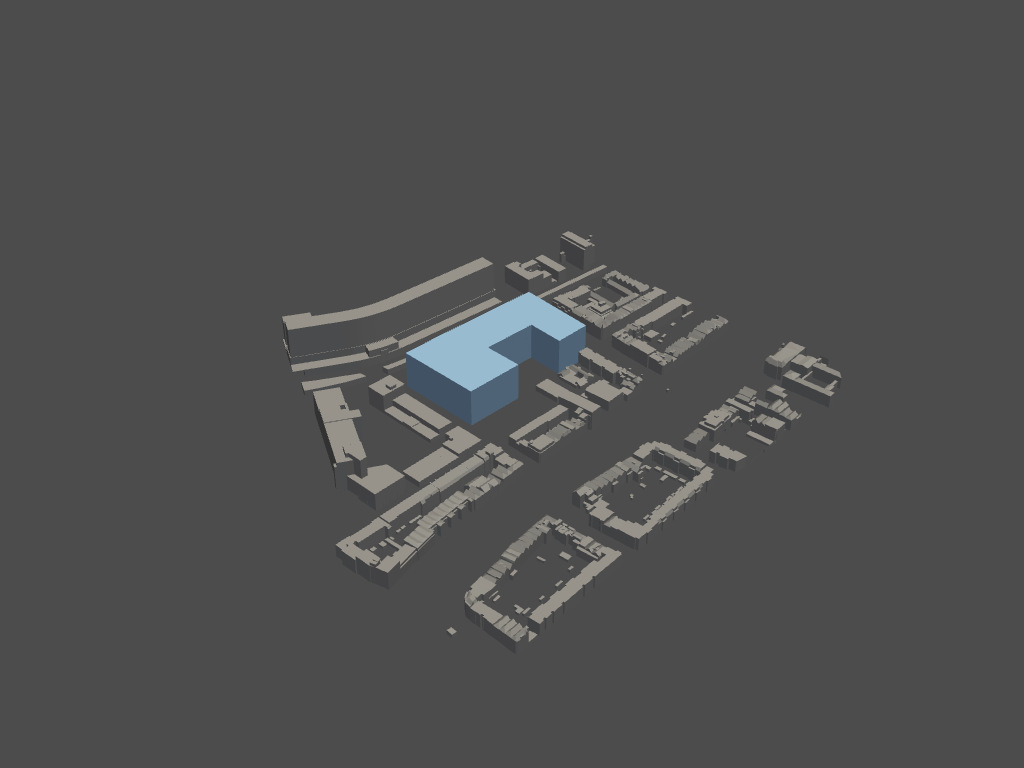

[(785.6075686833789, 708.1911636833788, 743.2184808333789),
 (65.08283250000001, -12.333572500000002, 22.69374465),
 (0.0, 0.0, 1.0)]

In [104]:
# initiating the plotter
p = pv.Plotter(notebook=True)

# adding the meshes
p.add_mesh(tri_to_pv(envelope_mesh), color='#abd8ff')
p.add_mesh(tri_to_pv(context_mesh), color='#aaaaaa')

# plotting
p.show()

In [105]:
lattice_path = os.path.relpath('../data/meshes/voxelized_envelope.csv')
envelope_lattice = tg.lattice_from_csv(lattice_path)

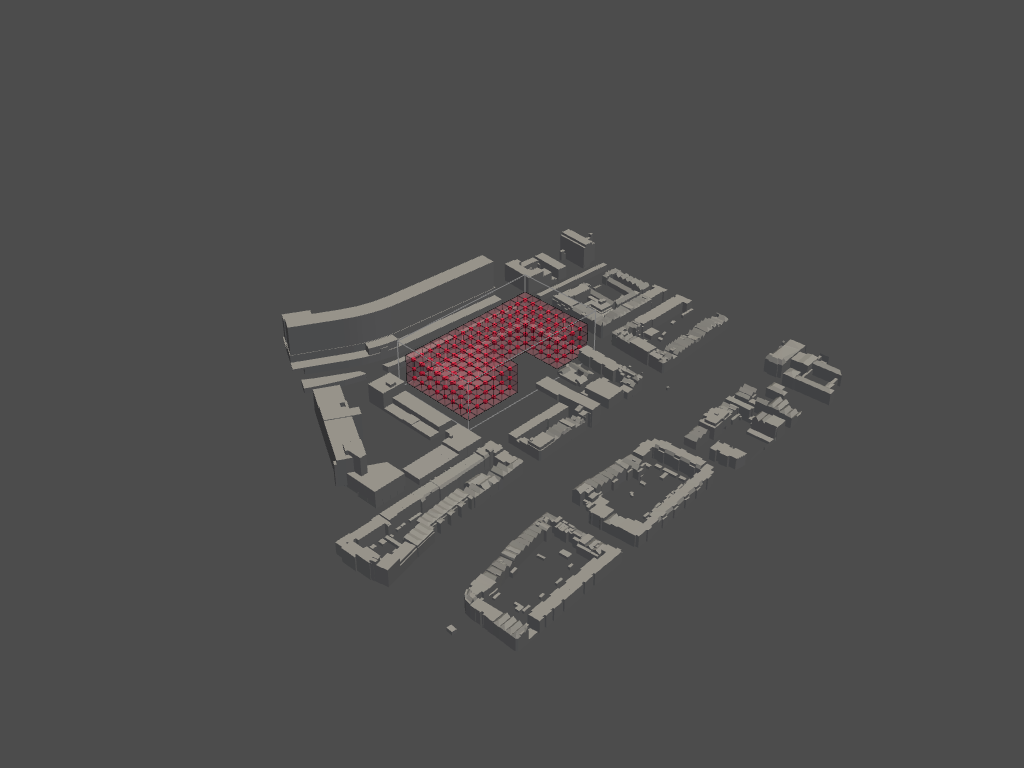

[(786.0208492040549, 708.604444204055, 741.1317613540549),
 (65.08283250000001, -12.333572500000002, 20.19374465),
 (0.0, 0.0, 1.0)]

In [106]:
# initiating the plotter
p = pv.Plotter(notebook=True)

# adding the meshes
envelope_lattice.fast_vis(p)
p.add_mesh(tri_to_pv(context_mesh), color='#aaaaaa')

# plotting
p.show()

In [107]:
sphere_mesh = tm.creation.icosphere(subdivisions=3, radius=1000, color=None)

In [108]:
sky_cloud = tg.cloud(sphere_mesh.vertices[np.where(sphere_mesh.vertices[:,2] > 0)])
print(len(sky_cloud))

305


In [109]:
p = pv.Plotter(notebook=True)

# adding the meshes
sky_cloud.fast_notebook_vis(p)
envelope_lattice.fast_vis(p)
#p.add_mesh(tri_to_pv(sphere_mesh), color='#aaaaaa', style='wireframe')
p.add_mesh(tri_to_pv(context_mesh), color='#aaaaaa')
# plotting
p.show(use_ipyvtk=True)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

[(3315.4414475578824, 3315.4414475578824, 3812.9414475578824),
 (0.0, 0.0, 497.5),
 (0.0, 0.0, 1.0)]

In [110]:
ray_srcs = np.tile(envelope_lattice.centroids, [1, len(sky_cloud)]).reshape(-1, 3)
ray_dirs = np.tile(sky_cloud, [len(envelope_lattice.centroids), 1]) - ray_srcs


In [111]:
tri_id, ray_id = context_mesh.ray.intersects_id(ray_origins=ray_srcs, ray_directions=ray_dirs, multiple_hits=False)

In [112]:
hits = np.full((len(ray_dirs)), 0)
hits[ray_id] = 1
hits = hits.reshape(len(envelope_lattice.centroids), -1)
voxel_hits = np.sum(hits, axis=1)
vox_sun_acc = 1.0 - voxel_hits / len(sky_cloud)

In [113]:
env_in_lattices_id = envelope_lattice.indices.flatten()[envelope_lattice.flatten()]
all_vox_sun_acc = np.full(len(envelope_lattice.flatten()), 0.0)
all_vox_sun_acc[env_in_lattices_id] = vox_sun_acc
all_vox_sun_acc = all_vox_sun_acc.reshape(envelope_lattice.shape)
all_vox_sun_acc_lattices = tg.to_lattice(all_vox_sun_acc, envelope_lattice)


invalid value encountered in true_divide


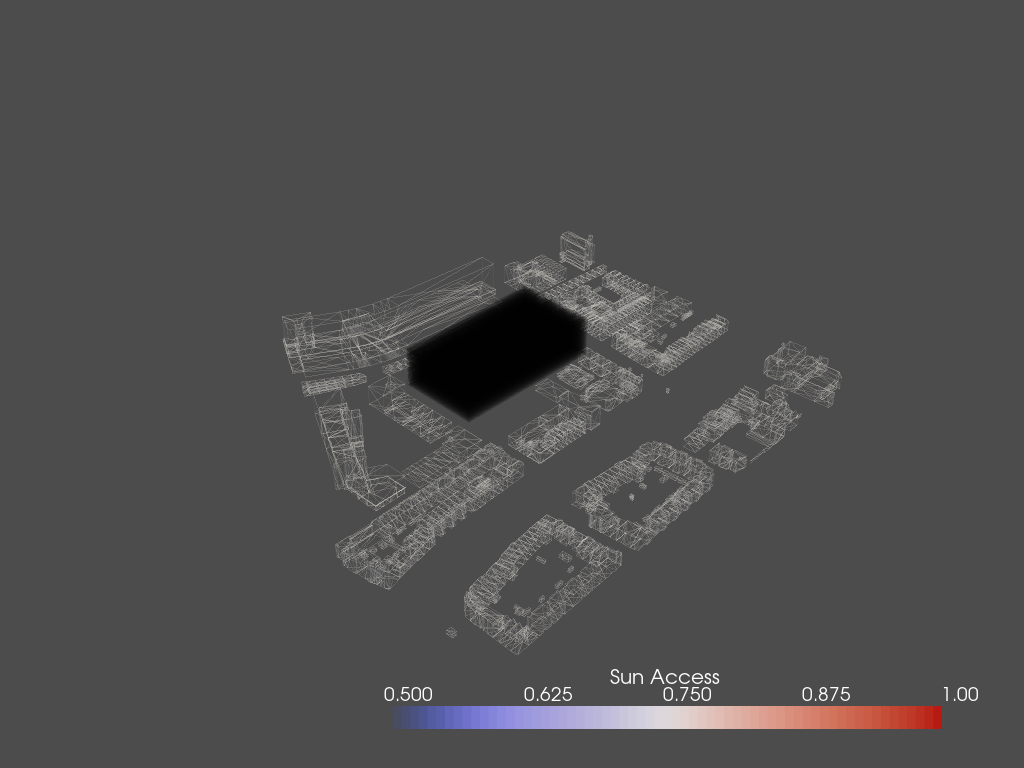

[(785.6075686833789, 708.1911636833788, 743.2184808333789),
 (65.08283250000001, -12.333572500000002, 22.69374465),
 (0.0, 0.0, 1.0)]

In [114]:
# initiating the plotter
p = pv.Plotter(notebook=True)

l = all_vox_sun_acc_lattices
# remapping
#l = 250 * (l - l.min()) / l.max()

# Create the spatial reference
grid = pv.UniformGrid()

# Set the grid dimensions: shape because we want to inject our values
grid.dimensions = l.shape
# The bottom left corner of the data set
grid.origin = l.minbound
# These are the cell sizes along each axis
grid.spacing = l.unit

# Add the data values to the cell data
grid.point_arrays["Sun Access"] = l.flatten(order="F")  # Flatten the Lattice

# adding the meshes
p.add_mesh(tri_to_pv(context_mesh), opacity=0.1, style='wireframe')
    
# adding the volume
opacity = np.array([0,0.6,0.6,0.6,0.6,0.6,0.6])*1.5
p.add_volume(grid, cmap="coolwarm", clim=[0.5, 1.0],opacity=opacity, shade=True)

# plotting
p.show()